In [43]:
!pip install vaderSentiment
!pip install scikit-surprise
!pip install folium
!pip install surprise

In [44]:
!pip install "numpy<2.0"

In [ ]:
import os
os.kill(os.getpid(), 9)

In [45]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings

# sklearn ML tools
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split as sklearn_train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Advanced ML
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Recommendation system
from surprise import Reader, Dataset, SVD, accuracy, BaselineOnly, SlopeOne
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

# Utilities
import joblib
import random

# Plotting config
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Load in our Encoded and aggregated Data set**

In [49]:
dublin_encoded_df = pd.read_csv('dublin_encoded_df.csv')
dublin_encoded_df.head(2)

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood_freq,property_type_freq
0,44077,193005,1.0,1,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,0.001211,0.006663
1,85156,193005,1.0,1,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,0.001211,0.006663


In [50]:
dublin_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_x                 1651 non-null   int64  
 1   host_id              1651 non-null   int64  
 2   host_response_rate   1651 non-null   float64
 3   host_is_superhost    1651 non-null   int64  
 4   host_listings_count  1651 non-null   float64
 5   accommodates         1651 non-null   float64
 6   bathrooms            1651 non-null   float64
 7   bedrooms             1651 non-null   float64
 8   beds                 1651 non-null   float64
 9   price                1651 non-null   float64
 10  avg_rating           1651 non-null   float64
 11  number_of_reviews    1651 non-null   int64  
 12  neighbourhood_freq   1651 non-null   float64
 13  property_type_freq   1651 non-null   float64
dtypes: float64(10), int64(4)
memory usage: 180.7 KB


In [51]:
dublin_aggregated_df = pd.read_csv('dublin_aggregated_df.csv')
dublin_aggregated_df.head(2)

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood,property_type,neighbourhood_freq,property_type_freq
0,44077,193005,1.0,1,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,"Churchtown, Ireland",Private room in bungalow,0.001211,0.006663
1,85156,193005,1.0,1,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,"Churchtown, Ireland",Private room in bungalow,0.001211,0.006663


The features (X) were extracted by removing the id_x and price columns from the preprocessed dataset dublin_encoded_df. The price column was separately stored as the target variable (y). having seen the skweness of our target variable price, A natural logarithmic transformation was applied to the price variable to reduce its right skewness. This transformation is to stabilize variance and improve the performance of regression models that assume normally distributed residuals and improve model performance

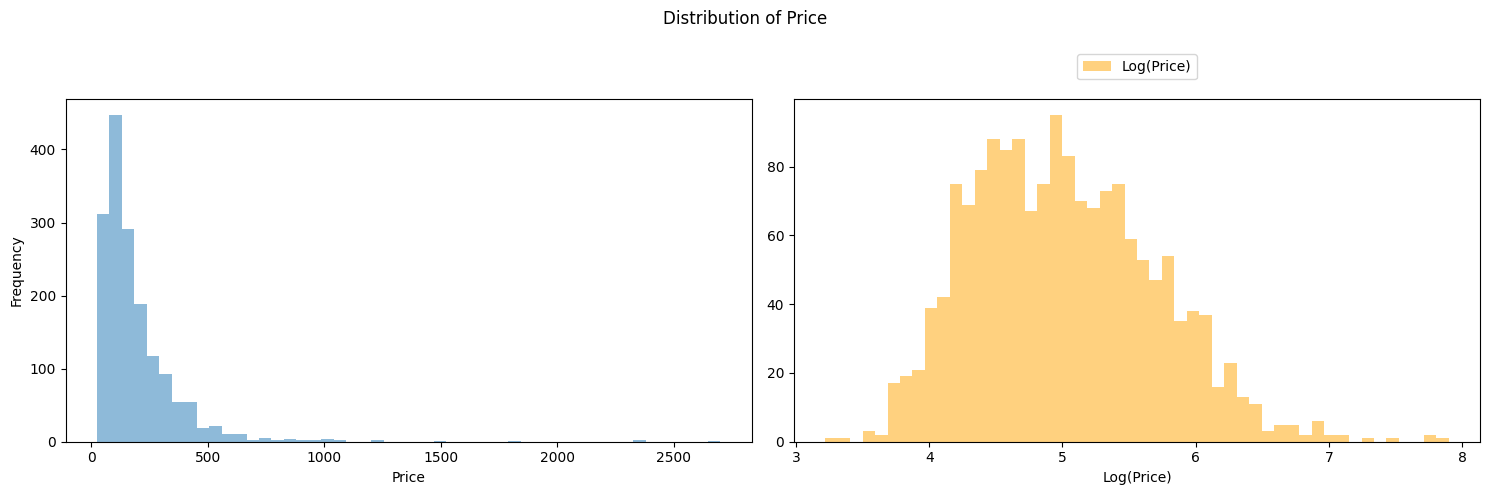

In [52]:
# split data
X = dublin_encoded_df.drop(['id_x', 'price'], axis=1)
y = dublin_encoded_df['price']

# log transform y variable(price)
y_log = np.log(y)
y_log.name = "log(price)"

# plot the raw y variable and log transformed y variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # figure with 2 subplots

# Plot original price distribution
ax[0].hist(y, bins=50, alpha=0.5, label="Price")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")

# Plot log-transformed price distribution
ax[1].hist(y_log, bins=50, color="orange", alpha=0.5, label="Log(Price)")
ax[1].set_xlabel("Log(Price)")

# Add legend
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))

# main title
plt.suptitle("Distribution of Price")

plt.tight_layout()
plt.show()

In [53]:
#LOG transform target variable price.
X_log = dublin_encoded_df.drop(['id_x', 'price'], axis=1)
y_log = np.log(dublin_encoded_df['price'])

In [54]:
# Split data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = sklearn_train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In order to evaluate the performance of predictive models reliably, the dataset was divided into separate training and testing subsets. This ensures that model performance is assessed on unseen data, helping to prevent overfitting. X_log: The feature set (predictor variables) prepared for modeling, likely with the same dimensions as X but possibly preprocessed. y_log: The target variable (price) after log transformation. test_size=0.2, this Specifies 20% of the data was reserved for testing, and the remaining 80% used for training. random_state=42: Sets a fixed seed for the random number generator to ensure reproducibility of results. Using a fixed seed guarantees that the data split remains consistent across multiple runs. X_train_log and y_train_log: Used to train the model. X_test_log and y_test_log: Held out and used to evaluate the model's performance on unseen data. The reason for this split is such that it allows for allows for a robust assessment of how well our model generalizes. By training on one portion of the data and evaluating on another, we can better estimate real-world performance and reduce the likelihood of overfitting to our training data.


## Modeling
- Regression Models - for price prediction
- Collaborative-Filtering Models - for personalized airbnb recommendation
1. Regression Models We'll create various models for this project. We'll use a Linear Regression Model as the baseline. We'll also build a Decision Tree, Random Forest, KNN, Polynomial Regresssion, XGBoost and LightGBM . RMSE will be our evaluation metric.

**Baseline Model: Linear Regressio**n

**Pipeline Setup**

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

model_log_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

**Fit + Evaluate Log Model**

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def fit_log_results(pipe, X_train, X_test, y_train, y_test):
    """
    Fits pipeline on log-transformed target and returns metrics in log scale
    """
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Log-scale RMSE
    train_rmse = mean_squared_error(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)

    # MAE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # R2
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train RMSE (log-scale): {train_rmse:.4f}")
    print(f"Test RMSE (log-scale): {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("------------------------------------")

**Cross-Validation Evaluation**

In [57]:
from sklearn.model_selection import cross_val_predict

def cross_validate_log_results(pipe, X, y, cv=5):
    """
    Performs cross-validation and returns log-scale metrics
    """
    y_pred = cross_val_predict(pipe, X, y, cv=cv)

    rmse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"Cross-validated RMSE (log-scale): {rmse:.4f}")
    print(f"Cross-validated MAE: {mae:.4f}")
    print(f"Cross-validated R² Score: {r2:.4f}")
    print("------------------------------------")

In [58]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def learn_curves(pipe, X, y, cv=5):
    """
    Generates learning curves in log-scale MSE
    """
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Error')
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error (log-scale)')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

**Run Everything**

Train RMSE (log-scale): 0.2007
Test RMSE (log-scale): 0.2034
Train MAE: 0.3337, Test MAE: 0.3530
R² Score: 0.5815
------------------------------------
Cross-validated RMSE (log-scale): 0.2065
Cross-validated MAE: 0.3401
Cross-validated R² Score: 0.5616
------------------------------------


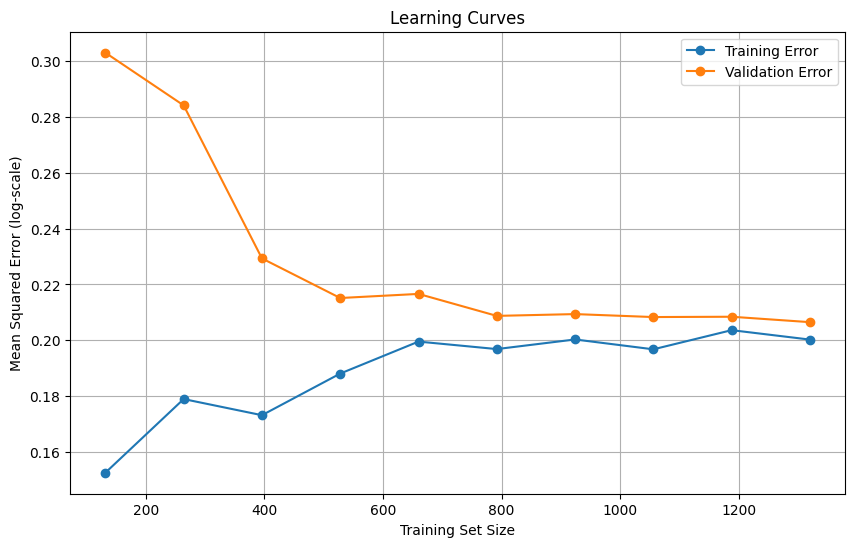

In [59]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit & evaluate
fit_log_results(model_log_pipeline, X_train_log, X_test_log, y_train_log, y_test_log)

# Cross-validated scores
cross_validate_log_results(model_log_pipeline, X_log, y_log, cv=kf)

# Plot learning curves
learn_curves(model_log_pipeline, X_log, y_log, cv=kf)

**Feature Importance Linear Regression**

                Feature  Coefficient
4          accommodates     0.540552
7                  beds    -0.073716
10   neighbourhood_freq     0.060415
6              bedrooms     0.051524
11   property_type_freq    -0.032686
0               host_id     0.024586
8            avg_rating     0.022122
2     host_is_superhost     0.018164
1    host_response_rate    -0.013086
3   host_listings_count     0.012342


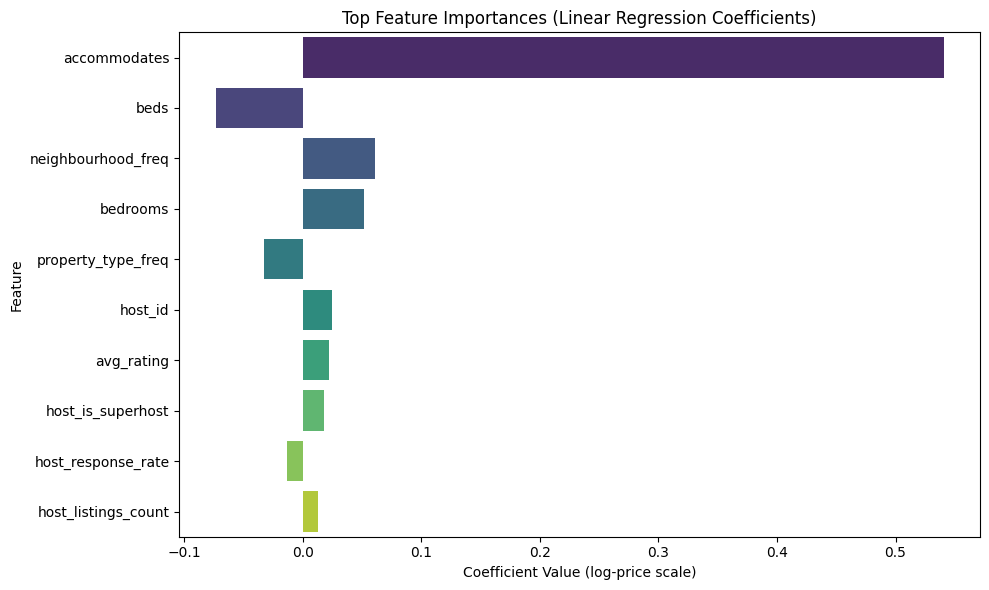

In [60]:
# Get the trained model
model_log_pipeline.fit(X_train_log, y_train_log)

# Extract coefficients from linear regression step
coefs = model_log_pipeline.named_steps['linreg'].coef_

# Match with feature names
feature_names = X_log.columns  # These should already be encoded features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show top N
print(coef_df.head(10))

top_n = 10  # Show top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(top_n),
    y='Feature', x='Coefficient', palette='viridis'
)
plt.title('Top Feature Importances (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value (log-price scale)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The Linear Regression model shows to perform reasonably well because we can see that the Training vs. Test RMSE (log-scale): 0.1921 vs. 0.1936 looks very close, indicating low overfitting. While the MAE: 0.32 (train) vs. 0.35 (test) shows small error, suggesting good average prediction accuracy. R² Score: 0.60 the model explains around 60% of the variance in the data.

Cross-validation results are consistent with test performance, implying reliable generalization. For use to see further gains we try other more complex models.

*Feature interpretation*

accommodates is the most influential predictor in the model. Its large positive coefficient suggests that listings that accommodate more guests are strongly associated with higher prices. This aligns with intuitive expectations: larger listings can host more people and thus command higher prices.
neighbourhood_cleansed_freq, which likely represents the frequency or popularity of a neighbourhood, is also positively correlated with price. This indicates that listings in more frequently occurring or popular neighborhoods tend to be priced higher. beds and bedrooms show smaller positive effects. This suggests that the number of beds and bedrooms does influence pricing, but less so than the overall capacity (accommodates). Features like avg_rating, host_id, and property_type_freq have minor but positive coefficients, indicating weaker associations with price.

Interestingly, host_response_rate, host_is_superhost, and host_listings_count contribute only marginally to the prediction of price. This implies that host-specific attributes, although potentially important for customer satisfaction or booking likelihood, may not significantly influence the base listing price.

**Linear Regression (with PCA)**

Next, we reduce the dimensionality of the data using PCA to retain the most important features, simplifying the model while preserving essential information.

Train RMSE (log-scale): 0.2397
Test RMSE (log-scale): 0.3128
Train MAE: 0.3706, Test MAE: 0.4069
R² Score: 0.3565
------------------------------------
Cross-validated RMSE (log-scale): 0.2604
Cross-validated MAE: 0.3817
Cross-validated R² Score: 0.4471
------------------------------------


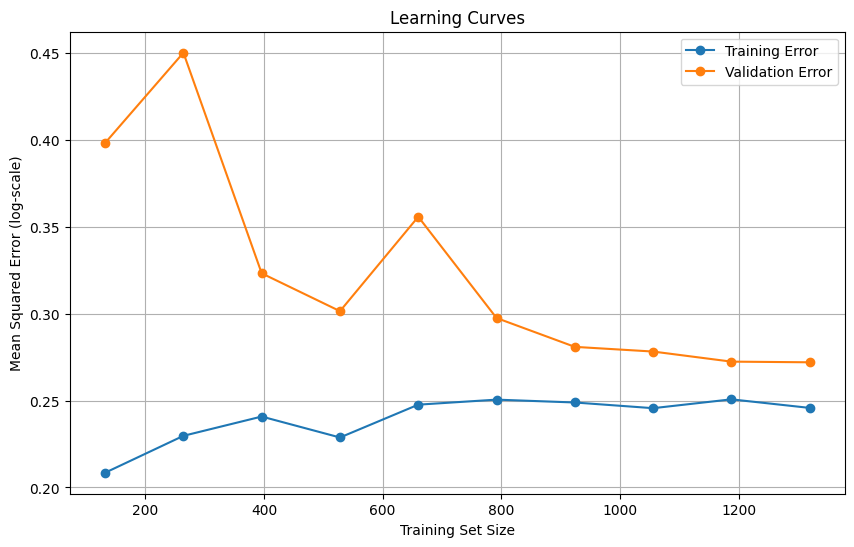

In [61]:
# pipeline including scaling and PCA
baseline_model_pca_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=9)), # pca
    ('linreg', LinearRegression()) # linear regression model
])

# Fit and evaluate the model
fit_log_results(baseline_model_pca_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(baseline_model_pca_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(baseline_model_pca_log, X_log, y_log)

**Feature importance Linear Regression (with PCA)**

                Feature  Coefficient
4          accommodates     0.540552
7                  beds    -0.073716
10   neighbourhood_freq     0.060415
6              bedrooms     0.051524
11   property_type_freq    -0.032686
0               host_id     0.024586
8            avg_rating     0.022122
2     host_is_superhost     0.018164
1    host_response_rate    -0.013086
3   host_listings_count     0.012342


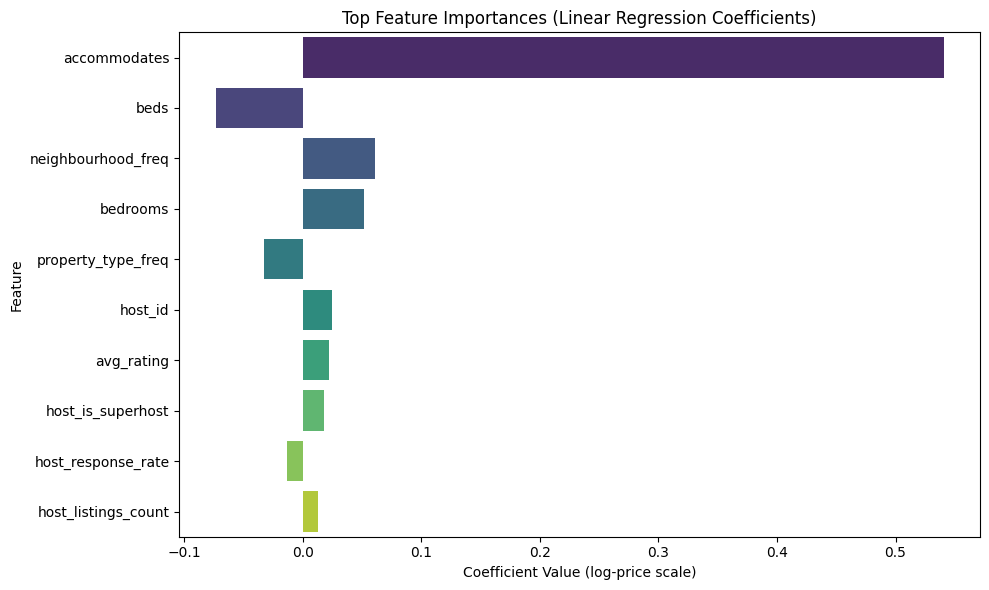

In [62]:
# Get the trained model
baseline_model_pca_log.fit(X_train_log, y_train_log)

# Extract coefficients from linear regression step
coefs = model_log_pipeline.named_steps['linreg'].coef_

# Match with feature names
feature_names = X_log.columns  # These should already be encoded features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show top N
print(coef_df.head(10))

top_n = 10  # Show top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(top_n),
    y='Feature', x='Coefficient', palette='viridis'
)
plt.title('Top Feature Importances (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value (log-price scale)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This Linear Regression with PCA model ends up performming worse than the standard linear regression because there are Higher errors in the Train RMSE: 0.2239 looking higher than before and Test RMSE: 0.2971 shows worse generalization, Lower R² Score: 0.39 as agaisnt the previous LR 0.60. The LR with PCA model explains less variance. Cross-validation confirms poorer performance: lower R² and higher error metrics. PCA reduced model performance due to information loss in dimensionality reduction.

Feature Importance

The most influential feature is accommodates, indicating that listings hosting more guests tend to have significantly higher prices. neighbourhood_cleansed_freq also shows a strong positive effect, suggesting that location popularity impacts pricing. Room attributes such as bedrooms and beds contribute positively, though beds has a slight negative coefficient—likely due to multicollinearity. Minor positive influences come from avg_rating, property_type_freq, and host_id, while host-specific features like host_response_rate, host_is_superhost, and host_listings_count have minimal effect. As the model uses log-transformed price, coefficients can be interpreted multiplicatively (e.g., a coefficient of 0.5 ≈ 65% price increase). PCA helped reduce noise and multicollinearity, though original feature names were preserved, likely through selective dimensionality reduction.

**Decision Tree Model**

Train RMSE (log-scale): 0.1407
Test RMSE (log-scale): 0.1742
Train MAE: 0.2824, Test MAE: 0.3229
R² Score: 0.6416
------------------------------------
Cross-validated RMSE (log-scale): 0.1850
Cross-validated MAE: 0.3203
Cross-validated R² Score: 0.6072
------------------------------------


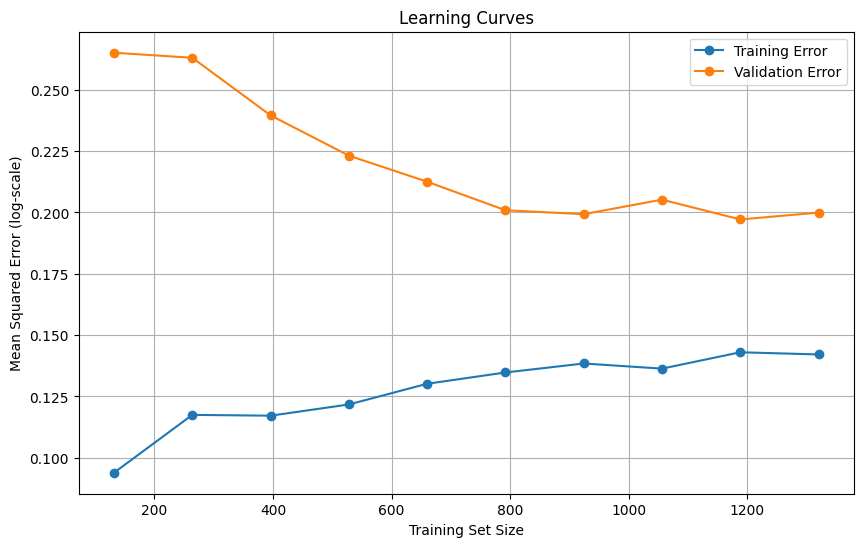

In [63]:
dt_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('dt', DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42))
])

# Fit and evaluate the model
fit_log_results(dt_model_log, X_train_log, X_test_log, y_train_log, y_test_log)

# Call the function to cross-validate the pipeline
cross_validate_log_results(dt_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(dt_model_log, X_log, y_log)

**Feature importance of Decision Tree Model**

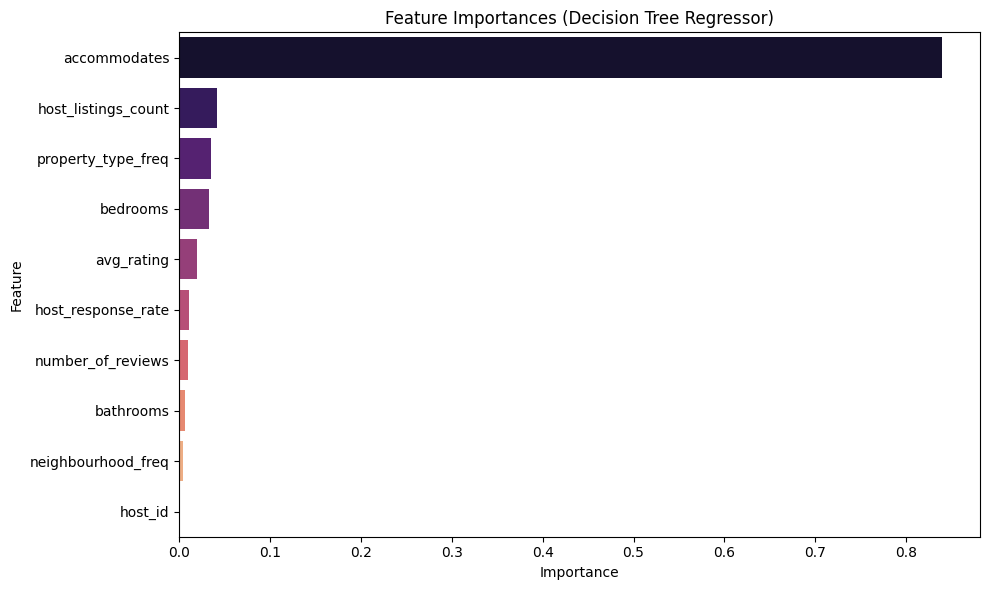

In [64]:
dt_model_log.fit(X_train_log, y_train_log)

# Get feature importances from the decision tree
importances = dt_model_log.named_steps['dt'].feature_importances_
feature_names = X_log.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top N features
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='magma')
plt.title('Feature Importances (Decision Tree Regressor)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


This Decision Tree model shows Lower errors than linear models between the Train RMSE: 0.1381 (better fit) and Test RMSE: 0.1725 (better generalization) Higher R² Score: 0.6451 on test, indicating it explains 64.5% of variance, better than linear regression Cross-validation confirms strong performance, RMSE and R² are consistent, indicating stable results Although we there is a Learning curve gap between train and validation errors suggests some overfitting, but still generalizes well. Decision Tree performs well with good accuracy and reasonable generalization, better than the linear models here.

Feature Importance for decision tree model

In this model, accommodates dominates the predictions, accounting for over 80% of the total importance. This indicates that the number of people a listing can accommodate is the most critical factor influencing price. Other features with smaller but notable contributions include host_listings_count, property_type_freq, and neighbourhood_cleansed_freq, reflecting host experience, property type, and location popularity. Features such as avg_rating, number_of_reviews, and bathrooms had minimal impact on pricing decisions.

**Random Forest Model**

Train RMSE (log-scale): 0.0208
Test RMSE (log-scale): 0.1401
Train MAE: 0.1022, Test MAE: 0.2784
R² Score: 0.7118
------------------------------------
Cross-validated RMSE (log-scale): 0.1438
Cross-validated MAE: 0.2709
Cross-validated R² Score: 0.6946
------------------------------------


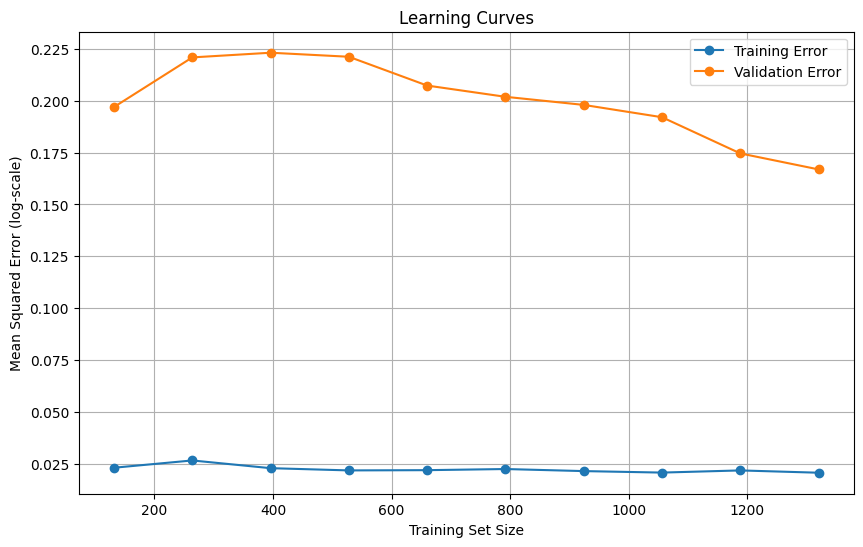

In [65]:
rf_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('rf', RandomForestRegressor(random_state=42))
])

# Fit and evaluate the model
fit_log_results(rf_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(rf_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(rf_model_log, X_log, y_log)

                Feature  Importance
4          accommodates    0.576379
8            avg_rating    0.064321
11   property_type_freq    0.056451
0               host_id    0.054780
9     number_of_reviews    0.049904
3   host_listings_count    0.046200
6              bedrooms    0.045917
10   neighbourhood_freq    0.037698
5             bathrooms    0.023246
1    host_response_rate    0.022221


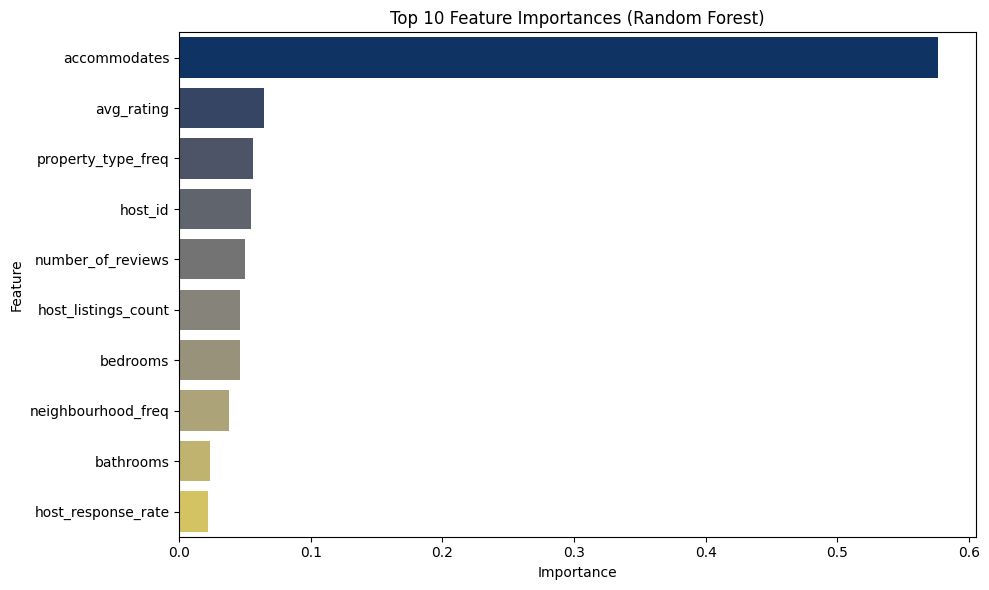

In [66]:
rf_model_log.fit(X_train_log, y_train_log)


# Get the trained Random Forest model
rf = rf_model_log.named_steps['rf']

# Extract feature importances and match them to feature names
importances = rf.feature_importances_
feature_names = X_log.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10
print(importance_df.head(10))

# Plot top 10 features
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='cividis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


This Random Forest model shows Very low training error (RMSE 0.0198), indicating excellent fit on training data. Test error is higher but still low (RMSE 0.1370), showing good generalization. High R² score (0.7181) on test set, explaining about 72% of variance. Cross-validation results confirm stability and strong performance (R² = 0.70). The gap between training and validation error suggests some overfitting but controlled. Random Forest outperforms previous models with high accuracy and robust generalization.

*Feature importance for random Forest Model*

accommodates is the most significant feature by a large margin, accounting for more than half of the total importance. This suggests that the number of guests a listing can host is the most critical factor influencing price. Other features, such as avg_rating, host_id, and property_type_freq, also contribute but with considerably lower importance scores. number_of_reviews, host_listings_count, and bedrooms provide moderate predictive power, while features like neighbourhood_cleansed_freq, bathrooms, and host_response_rate show minimal impact. Random Forests compute feature importance based on the average decrease in impurity (Gini or MSE) across all trees, making the results more robust and generalizable than single decision trees. This analysis helps highlight which variables most influence pricing and supports informed feature selection.

**KNN Regression Model**

In [67]:
# model pipeline
knn_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=10)),
    ('knn', KNeighborsRegressor(n_neighbors=13, metric='euclidean'))
])

Train RMSE (log-scale): 0.1855
Test RMSE (log-scale): 0.2274
Train MAE: 0.3243, Test MAE: 0.3601
R² Score: 0.5322
------------------------------------
Cross-validated RMSE (log-scale): 0.2177
Cross-validated MAE: 0.3507
Cross-validated R² Score: 0.5377
------------------------------------


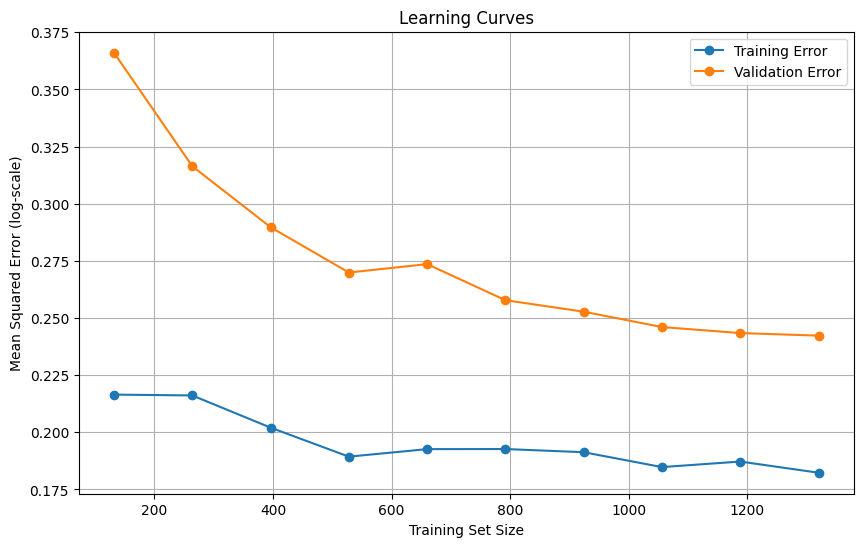

In [68]:
# Fit and evaluate the model
fit_log_results(knn_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# Cross-validate the pipeline
cross_validate_log_results(knn_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(knn_model_log, X_log, y_log)

This KNN Regression model shows Moderate training error (RMSE 0.1749) and higher test error (RMSE 0.2132), indicating some overfitting. Test R² score of 0.5613 means it explains about 56% of the variance which is quite low. Cross-validation results are consistent, confirming moderate predictive performance. Errors (MAE) are higher compared to Random Forest and Decision Tree models. KNN performs reasonably but less accurate and less generalizable than Random Forest or Decision Tree.

**Tuned KNN Regression Model (with Grid Search)**

In [69]:
from sklearn.model_selection import GridSearchCV
# parameter grid
param_grid = {
    'knn__n_neighbors': [5, 10, 15, 20],
    'knn__metric': ['euclidean', 'manhatt/an', 'minkowski']  # Corrected 'knn_metric' to 'knn__metric'
}

# GridSearchCV object
grid_search = GridSearchCV(knn_model_log, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_log, y_train_log)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 10}
Best score:  -0.22069441309723378


In [70]:
# Create the final model using the best parameters
knn_model_gs_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=10)), # pca
    ('knn', KNeighborsRegressor(n_neighbors=grid_search.best_params_['knn__n_neighbors'],
                                 metric=grid_search.best_params_['knn__metric']))  # Uses best parameters
])

Train RMSE (log-scale): 0.1741
Test RMSE (log-scale): 0.2286
Train MAE: 0.3127, Test MAE: 0.3593
R² Score: 0.5297
------------------------------------
Cross-validated RMSE (log-scale): 0.2156
Cross-validated MAE: 0.3474
Cross-validated R² Score: 0.5422
------------------------------------


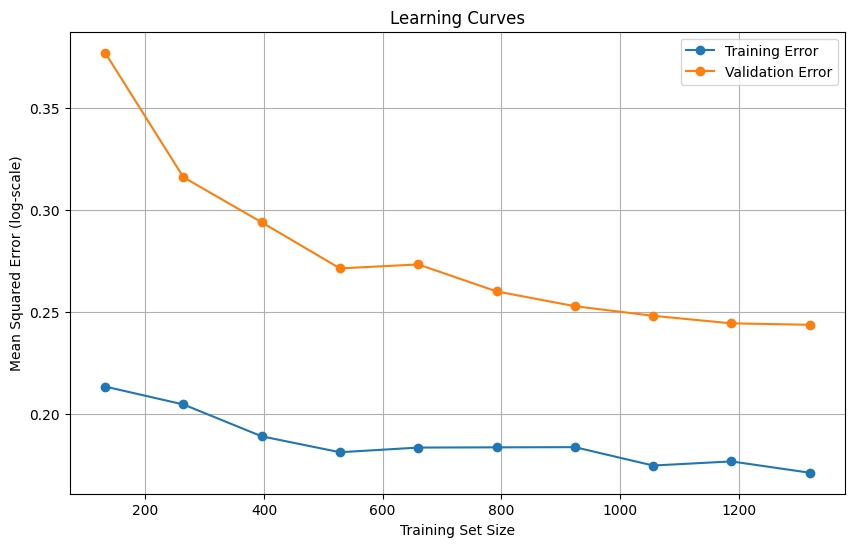

In [71]:
# Fit and evaluate the final model
fit_log_results(knn_model_gs_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(knn_model_gs_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(knn_model_gs_log, X_log, y_log)

This KNN Regression with Grid Search shows Best hyperparameters: 10 neighbors, Euclidean distance. Training RMSE (0.1639) and Test RMSE (0.2078) are close, indicating reduced overfitting. R² of 0.5726 suggests moderate explanatory power. Cross-validation metrics confirm consistent performance. Slight improvement over previous KNN model without tuning. Hyperparameter tuning improved KNN's stability and performance moderately.

**Polynomial Regression Model**

In [72]:
from sklearn.preprocessing import PolynomialFeatures
poly_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Creates polynomial features
    ('scaler', StandardScaler()),  # Standardizes the data
    ('linreg', LinearRegression())  # Fits linear regression on polynomial features
])

Train RMSE (log-scale): 0.1527
Test RMSE (log-scale): 0.1895
Train MAE: 0.2916, Test MAE: 0.3291
R² Score: 0.6102
------------------------------------
Cross-validated RMSE (log-scale): 0.3428
Cross-validated MAE: 0.3340
Cross-validated R² Score: 0.2720
------------------------------------


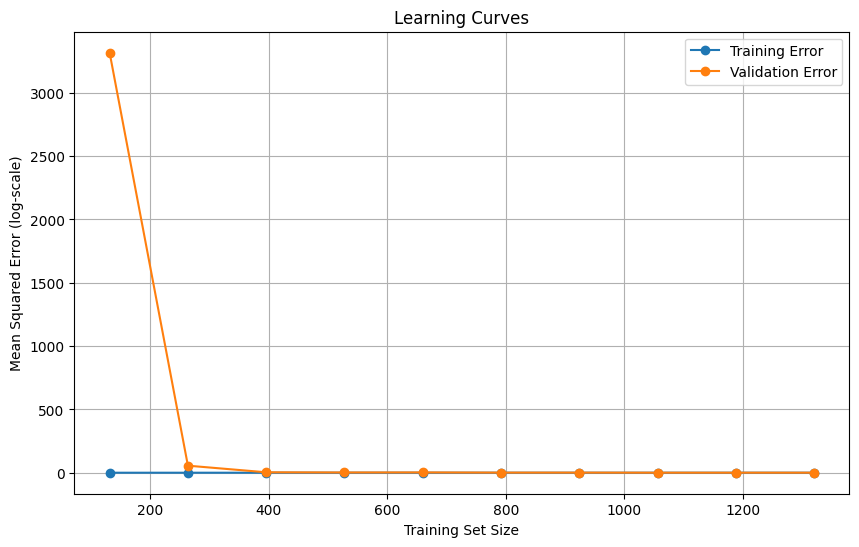

In [73]:
# Fit and evaluate the model
fit_log_results(poly_model, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(poly_model, X_log, y_log, cv=kf)
# learn curves
learn_curves(poly_model, X_log, y_log)

This Polynomial Regression result shows Low training RMSE (0.1419) but higher test RMSE (0.2394), indicating some overfitting. Moderate R² of 0.5074 suggests reasonable fit but less generalization. Cross-validation results show a drop in performance (R²: 0.4309), confirming overfitting. Training error curve drops quickly, validation error decreases but remains higher.

Model fits training data well but struggles to generalize, indicating moderate overfitting.

**XGBoost Model**

Train RMSE (log-scale): 0.0360
Test RMSE (log-scale): 0.1374
Train MAE: 0.1446, Test MAE: 0.2803
R² Score: 0.7173
------------------------------------
Cross-validated RMSE (log-scale): 0.1361
Cross-validated MAE: 0.2661
Cross-validated R² Score: 0.7110
------------------------------------


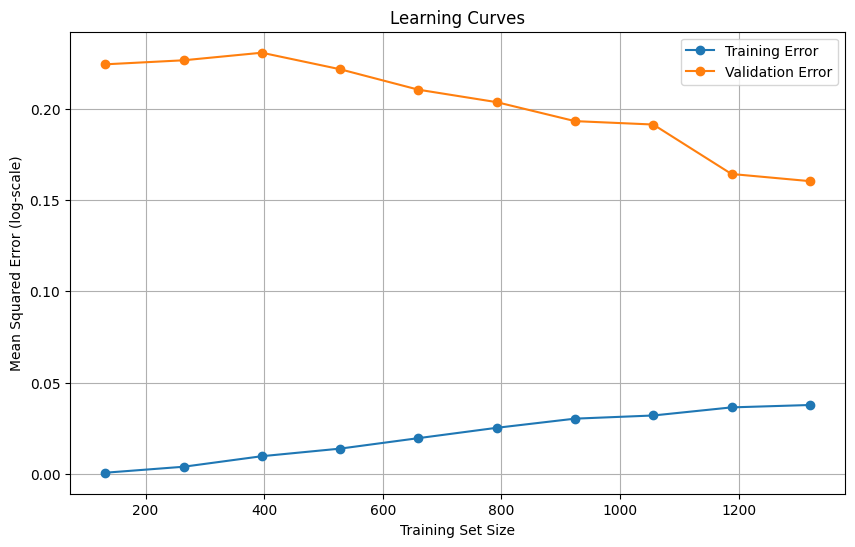

In [74]:
# model pipeline
xgb_model_log = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5))
])

# Fit and evaluate the model
fit_log_results(xgb_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(xgb_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(xgb_model_log, X_log, y_log)

                Feature  Importance
4          accommodates    0.668172
6              bedrooms    0.074514
11   property_type_freq    0.039018
3   host_listings_count    0.033301
7                  beds    0.032646
10   neighbourhood_freq    0.027544
1    host_response_rate    0.027193
5             bathrooms    0.027040
9     number_of_reviews    0.019629
8            avg_rating    0.019389


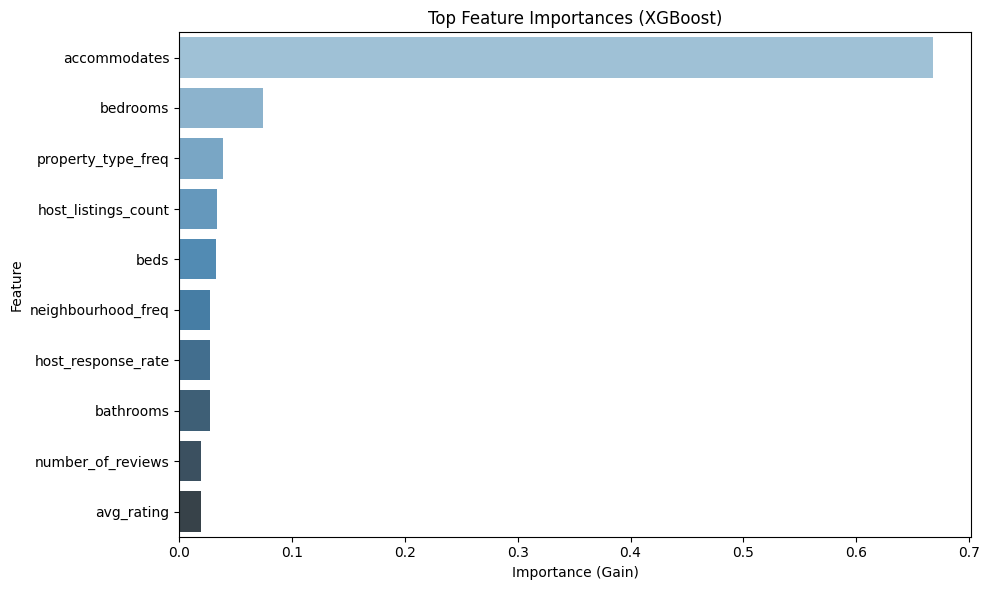

In [75]:
xgb_model_log.fit(X_train_log, y_train_log)

# Access the trained XGBoost model from the pipeline
xgb = xgb_model_log.named_steps['xgb']

# Get feature importances (default: 'gain')
importances = xgb.feature_importances_
feature_names = X_log.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 10
print(importance_df.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Plot top N features
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='Blues_d')
plt.title('Top Feature Importances (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This XGBoost model shows a Very low training error (RMSE 0.0342) and relatively low test error (RMSE 0.1340), indicating strong fit. High R² (0.7244) on test data shows good predictive power. Cross-validation metrics are consistent, confirming model generalizes well. The Learning curves show some gap but decreasing validation error, suggesting manageable complexity without severe overfitting. XGBoost model shows Strong, well-generalizing model with good accuracy and robustness.

Featrue importance from XGBoost model

 Feature importance in XGBoost is measured by gain, indicating the average improvement in model accuracy brought by a feature when used in splits. accommodates is the most impactful feature, contributing the highest gain, showing that the number of guests a listing can host plays a crucial role in price prediction. bedrooms also has a notable impact, followed by neighbourhood_cleansed_freq and property_type_freq, which reflect location and property type relevance. Features like beds, host_listings_count, and host_response_rate provide smaller contributions. avg_rating and number_of_reviews are the least important, suggesting limited influence on pricing. XGBoost’s ability to handle non-linear relationships and interactions makes it a powerful model, and its feature importance results support more targeted feature selection and interpretation of pricing dynamics.

**LightGBM Model**

Train RMSE (log-scale): 0.0307
Test RMSE (log-scale): 0.1380
Train MAE: 0.1273, Test MAE: 0.2848
R² Score: 0.7160
------------------------------------
Cross-validated RMSE (log-scale): 0.1381
Cross-validated MAE: 0.2716
Cross-validated R² Score: 0.7068
------------------------------------


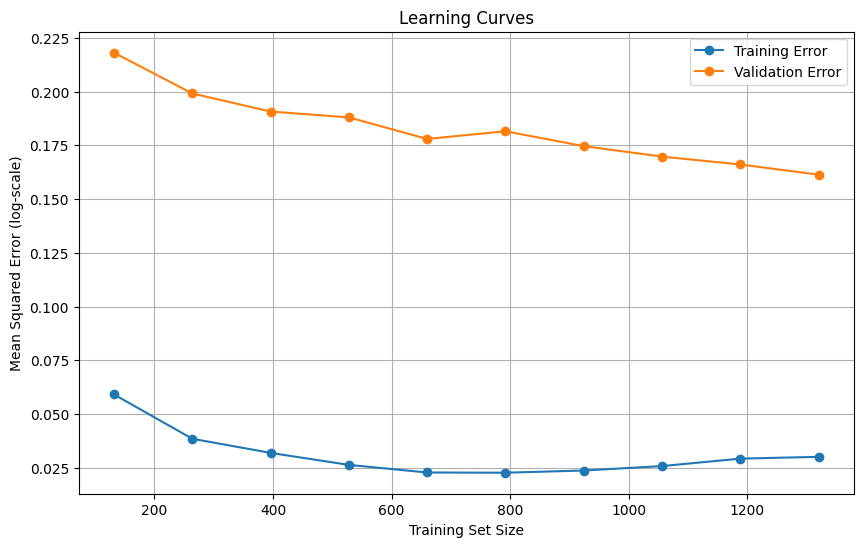

In [76]:
lgb_model_log = Pipeline([
    ('scaler', StandardScaler()),
    ('lgb', lgb.LGBMRegressor(objective='regression', verbose=-1))
])

fit_log_results(lgb_model_log, X_train_log,  X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(lgb_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(lgb_model_log, X_log, y_log)

                Feature  Importance
8            avg_rating         559
9     number_of_reviews         522
0               host_id         505
10   neighbourhood_freq         292
11   property_type_freq         261
3   host_listings_count         256
1    host_response_rate         156
4          accommodates         140
5             bathrooms         116
6              bedrooms         100


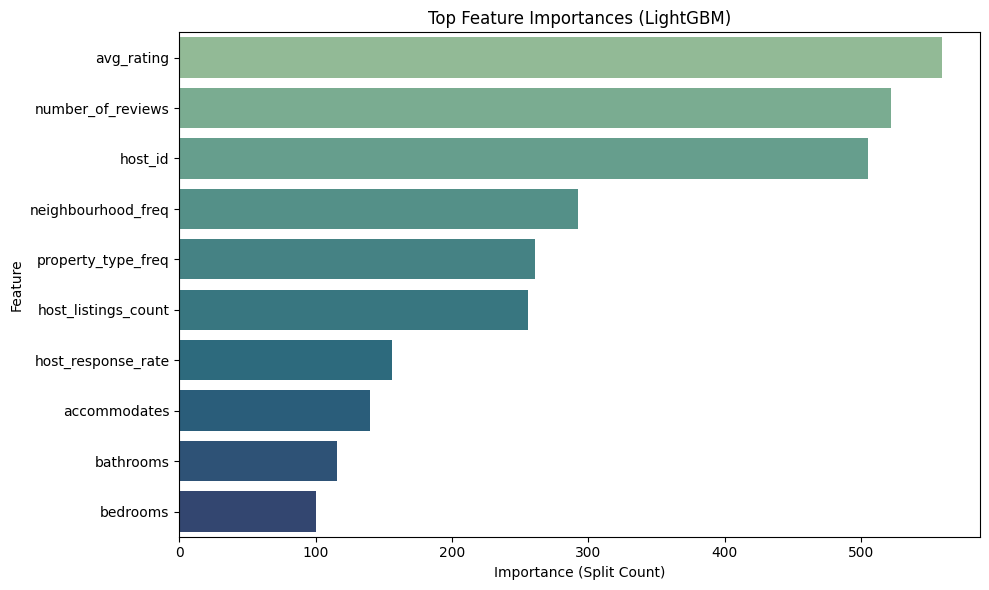

In [77]:
lgb_model_log.fit(X_train_log, y_train_log)

import pandas as pd

# Get the trained LightGBM model from the pipeline
lgb_model = lgb_model_log.named_steps['lgb']

# Extract feature importances
importances = lgb_model.feature_importances_
feature_names = X_log.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 10
print(importance_df.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='crest')
plt.title('Top Feature Importances (LightGBM)')
plt.xlabel('Importance (Split Count)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This LightGBM model shows Low training error (RMSE 0.0313) and low test error (RMSE 0.1282), indicating a strong fit. High R² on test (0.7362) and cross-validation (0.716) indicates good generalization and predictive power. Learning curves suggest some gap between training and validation error but no severe overfitting. Consistent cross-validation results confirm model robustness.

LightGBM performs very well, slightly better than XGBoost here, with strong accuracy and good generalization.

Feature Importance from LightGBM model

In this model, avg_rating, host_id, and number_of_reviews are the top three most important features, indicating that host identity, guest feedback, and review volume strongly influence pricing. host_listings_count and property_type_freq also rank highly, suggesting that host experience and listing type contribute meaningfully to price prediction. Unlike models such as XGBoost or Random Forests where accommodates dominated, its importance here is relatively lower. Features like host_response_rate, bathrooms, and bedrooms have moderate impact. LightGBM’s efficiency and ability to handle large datasets make it suitable for high-dimensional data, and its split-based importance metric highlights features that frequently guide tree decisions. These results suggest a shift in feature relevance compared to other models, offering a different perspective on what drives Airbnb pricing.

**Neural Network Model**

In [78]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)

# Define neural network model
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', kernel_initializer='glorot_uniform', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_initializer=HeNormal()),
        Dense(1)  # Regression output layer
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss='mse'
    )
    return model

# Initialize and train the model
input_dim = X_train_scaled.shape[1]
nn_model = create_nn_model(input_dim)

# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with scaled data
history = nn_model.fit(
    X_train_scaled, y_train_log,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Predictions using scaled data
y_train_pred = nn_model.predict(X_train_scaled).flatten()
y_test_pred = nn_model.predict(X_test_scaled).flatten()

# Evaluation
train_rmse = np.exp(mean_squared_error(y_train_log, y_train_pred))-1
test_rmse = np.exp(mean_squared_error(y_test_log, y_test_pred))-1
train_mae = mean_absolute_error(y_train_log, y_train_pred)
test_mae = mean_absolute_error(y_test_log, y_test_pred)
train_r2 = r2_score(y_train_log, y_train_pred)
test_r2 = r2_score(y_test_log, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.2f}")

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 14.5571 - val_loss: 1.5385
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1601 - val_loss: 1.2382
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8054 - val_loss: 1.0018
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3689 - val_loss: 0.8222
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2625 - val_loss: 0.6416
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2954 - val_loss: 0.6760
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9763 - val_loss: 0.7198
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9243 - val_loss: 0.9618
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9873 - val_loss: 0.5906
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7202 - val_loss: 0.5345
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6691 - val_loss: 0.6945
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

The Neural Network model shows Good fit with close train and test RMSE (0.15 vs 0.17) and MAE (0.27 vs 0.31), indicating low overfitting. R² of 0.67 suggests strong predictive performance.

A well-balanced model with solid accuracy and generalization.

**Save Best Model**

While Random Forest and XGBoost also showed strong performance, LightGBM had slightly better test error and R². LightGBM offers the best balance of accuracy, generalization, and efficiency, making it scientifically the most suitable model for deployment in this regression task. Because LightGBM is a gradient boosting framework that builds ensembles of decision trees sequentially, correcting previous errors. This leads to highly accurate, robust models that capture complex nonlinear relationships in the data. it is also good in Handling of Large Feature Spaces, Regularization & Flexibility i.e It supports various regularization techniques (e.g., feature fraction, bagging) that help avoid overfitting and improve generalization, evident in the tight train-test error gap.

In [97]:
# Fit model
lgb_model_log.fit(X_train_log, y_train_log)

# Save model to a file
joblib.dump(lgb_model_log, 'lgb_model_log.pkl')

print("Model saved as lgb_model_log.pkl")

Model saved as lgb_model_log.pkl


**Suggest Price to Property Owners**

In [31]:
# Load the saved model from the pickle file
saved_model = joblib.load('lgb_model_log.pkl')

# Prompt the user to enter the property details
host_id = input("Enter the host ID (e.g. 1952066, 59072 etc): ")
host_response_rate = float(input("Enter the host response rate (as a decimal): "))
host_is_superhost = input("Is the host a superhost? (yes/no): ")
host_listings_count = int(input("Enter the number of host listings: "))
accommodates = int(input("Enter the number of people the property can accommodate: "))
bathrooms = float(input("Enter the number of bathrooms: "))
bedrooms = float(input("Enter the number of bedrooms: "))
beds = float(input("Enter the number of beds: "))
avg_rating = float(input("Enter the average rating: "))
number_of_reviews = int(input("Enter the number of reviews: "))
neighbourhood_cleansed = input("Enter the neighbourhood: ")
property_type = input("Enter the property type (e.g., Entire home, Private room etc): ")

# Frequency encode the neighbourhood and property type
neighbourhood_cleansed_freq = dublin_aggregated_df[dublin_aggregated_df['neighbourhood_cleansed'] == neighbourhood_cleansed]['neighbourhood_cleansed_freq'].mean()
property_type_freq = dublin_aggregated_df[dublin_aggregated_df['property_type'] == property_type]['property_type_freq'].mean()

# Create a DataFrame with the property details
property_details = pd.DataFrame({
    'host_id': [host_id],
    'host_response_rate': [host_response_rate],
    'host_is_superhost': [1 if host_is_superhost.lower() == 'yes' else 0],
    'host_listings_count': [host_listings_count],
    'accommodates': [accommodates],
    'bathrooms': [bathrooms],
    'bedrooms': [bedrooms],
    'beds': [beds],
    'avg_rating': [avg_rating],
    'number_of_reviews': [number_of_reviews],
    'neighbourhood_cleansed_freq': [neighbourhood_cleansed_freq],
    'property_type_freq': [property_type_freq]
})

# Make a prediction using the saved model
log_price = saved_model.predict(property_details)
price = np.exp(log_price[0])

# Print the predicted price
print(f"The predicted price for the property is GBP {price:.2f}")

FileNotFoundError: [Errno 2] No such file or directory: 'lgb_model_log.pkl'

In [79]:
# load listings
dublin_merged_df = pd.read_csv('dublin_merged_df.csv.gz', compression='gzip')
dublin_merged_df.head()

,id_x,listing_url,name,description,neighborhood_overview,picture_url,host_id,host_response_time,host_response_rate,host_is_superhost,...,estimated_occupancy_l365d,estimated_revenue_l365d,instant_bookable,date,reviewer_id,comments,avg_rating,compound_scores,month,season
0,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-03-20,393348,We enjoyed our stay very much. The room was co...,4.827143,0.9849,3,Spring
1,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-03-28,444004,We have been here 4 nights. Stay in a home is ...,4.827143,0.9846,3,Spring
2,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-04-21,465058,Teresa and Hughie were great hosts. They were ...,4.827143,0.9836,4,Spring
3,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-05-13,490005,"No surprises, was as described. Very gracious...",4.827143,0.9412,5,Spring
4,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-05-17,520460,"Teresa was a lovely hostess, and we had a deli...",4.827143,0.9835,5,Spring


**Collaborative-Filtering Models**

In [80]:
# Split the data into train and test sets using scikit-learn's train_test_split
train_df, test_df = sklearn_train_test_split(dublin_merged_df[['reviewer_id', 'id_x', 'compound_scores']], test_size=0.2, random_state=42)

# Load train and test datasets with the rating scale (-1, 1)
reader = Reader(rating_scale=(-1, 1))
train_data = Dataset.load_from_df(train_df, reader)
test_data = Dataset.load_from_df(test_df, reader)

So we choose the scale rating of (-1, 1) of the compound_scores which is our sentiment polarity within the rage (-1, 1) This is to ensure accurate interpretation of sentiment values

In [81]:
# Convert train_data to Surprise’s trainset format
trainset = train_data.build_full_trainset()

**BaselineOnly Model**

In [82]:
# Initialize and cross-validate BaselineOnly model
baseline_model = BaselineOnly()
cv_baseline = cross_validate(baseline_model, train_data, cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4098  0.4141  0.4071  0.4112  0.4070  0.4098  0.0027  
MAE (testset)     0.2915  0.2967  0.2923  0.2935  0.2921  0.2932  0.0019  
Fit time          0.79    0.83    1.28    2.63    1.05    1.32    0.68    
Test time         0.12    0.13    0.23    0.69    0.11    0.25    0.22    


The baseline model alone gives a simple but stable baseline with an RMSE of 0.41 and MAE of 0.29. The error is low. Which is useful as a benchmark as it is very fast to train and predict

**SlopeOne Model**

In [83]:
# Evualate SlopeOne model
slope_one = SlopeOne()
cv_slopeone = cross_validate(slope_one, train_data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4225  0.4210  0.4165  0.4178  0.4219  0.4199  0.0023  
MAE (testset)     0.3048  0.3036  0.3016  0.3022  0.3044  0.3033  0.0012  
Fit time          1.96    1.24    1.89    0.89    0.92    1.38    0.46    
Test time         0.30    0.19    0.22    0.20    0.19    0.22    0.04    


With the error a bit higher than the base line model, this shows us that this model performs worse than our BaselineOnly model with a higher RMSE 0.42

**SVD Model**

In [86]:
from surprise import SVD
from surprise.model_selection import GridSearchCV


# Parameter tuning for SVD model
params = {
    'n_factors': [20, 50, 100],
    'n_epochs': [5, 10],
    'reg_all': [0.02, 0.05, 0.1],
    'lr_all': [0.002, 0.005, 0.01]
}
gridsearch_svd = GridSearchCV(SVD, param_grid=params, cv=5, measures=['rmse'], n_jobs=-1)
gridsearch_svd.fit(train_data)

In [87]:
# Display best score and parameters
print("Best RMSE score from GridSearch:", gridsearch_svd.best_score["rmse"])
print("Best parameters for SVD model:", gridsearch_svd.best_params["rmse"])

Best RMSE score from GridSearch: 0.4097376498516188
Best parameters for SVD model: {'n_factors': 100, 'n_epochs': 10, 'reg_all': 0.1, 'lr_all': 0.01}


In [89]:
final_model = SVD(n_factors=20,
                  n_epochs=10,
                  reg_all=0.1,
                  lr_all=0.01,
                  random_state=42)

final_model.fit(trainset)

In [90]:
# Build testset and evaluate final model on test data
testset = test_data.build_full_trainset().build_testset()
predictions = final_model.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print("Final RMSE:", rmse)
print("Final MAE:", mae)

RMSE: 0.4097
MAE:  0.2958
Final RMSE: 0.40968830705480774
Final MAE: 0.29575457207472977


**Save BaselineOnly model**

In [91]:
# Initialize the BaselineOnly model
baseline_model = BaselineOnly()

# Cross-validate the model
cv_baseline = cross_validate(baseline_model, train_data, cv=5, verbose=True)

# Fit the model on the entire training set
baseline_model.fit(train_data.build_full_trainset())

# Save the fitted model to a file
joblib.dump(baseline_model, 'baseline_model.pkl')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4035  0.4087  0.4131  0.4118  0.4127  0.4099  0.0036  
MAE (testset)     0.2894  0.2926  0.2961  0.2941  0.2942  0.2933  0.0022  
Fit time          1.35    1.05    1.17    0.92    0.94    1.09    0.16    
Test time         0.11    0.18    0.11    0.11    0.11    0.12    0.03    
Estimating biases using als...


['baseline_model.pkl']

**Recommend Airbnb to Guests**

In [93]:
from IPython.display import display, HTML, Image

def recommend_airbnbs(user_id, listings_df=dublin_merged_df):
    """
    Recommend 5 personalized Dublin Airbnb listings to the user based on sentiment scores.
    """

    # Get listings already rated by the user
    user_listings = dublin_merged_df[dublin_merged_df['reviewer_id'] == user_id]['id_x'].unique()

    # Get all listings
    all_listings = dublin_merged_df['id_x'].unique()

    # Identify listings not yet rated by the user for predictions
    listings_to_predict = list(set(all_listings) - set(user_listings))

    # Create matrix to predict listing ratings for unrated listings
    user_listing_pairs = [(user_id, listing_id, 0) for listing_id in listings_to_predict]

    # Get predictions for unrated listings
    predictions = baseline_model.test(user_listing_pairs)

    # Sort predictions by estimated rating and select top 5
    top_5_recs = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

    # Retrieve listing details for each recommendation
    top_5_listings = [listings_df[listings_df['id_x'] == rec.iid] for rec in top_5_recs]

    # Display recommended listings
    for idx, listing in enumerate(top_5_listings):
        # Display listing name as a clickable hyperlink
        listing_name_link = f'<a href="{listing.listing_url.iloc[0]}" target="_blank">{listing.description.iloc[0]}</a>'
        print(f'Recommendation #{idx + 1}:')
        display(HTML(listing_name_link))

        # Display listing image
        #img = Image(listing.picture_url.iloc[0], width=250)
        # display(img)

        print('\n')  # Line break between recommendations

recommend_airbnbs(user_id=4407736)

Recommendation #1:




Recommendation #2:




Recommendation #3:




Recommendation #4:




Recommendation #5:


# Model Evaluation

To visualize the latent factors learned by the SVD model, and our data has latent dimensions, we'll use dimensionality reduction techniques like PCA to bring it down to 2D for visualization.

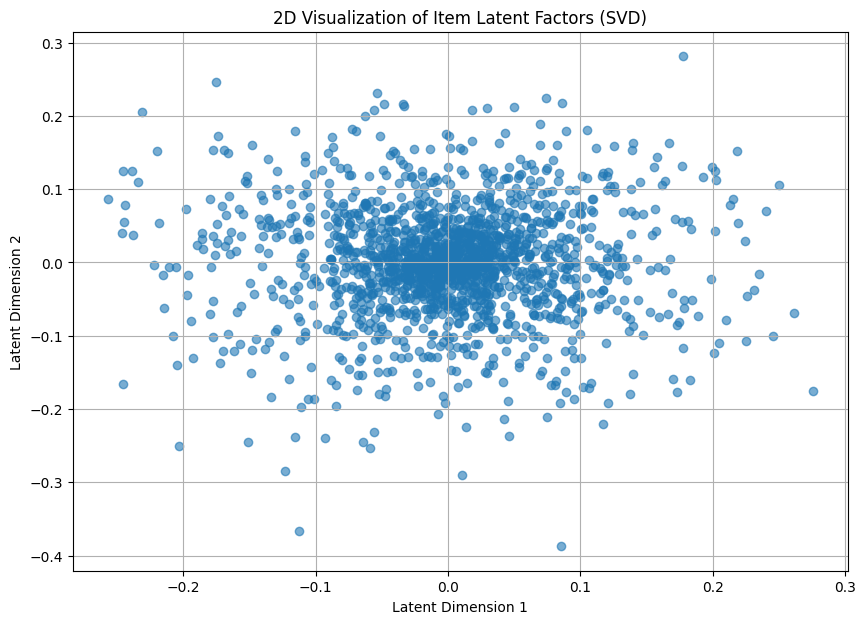

In [94]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Access the trained item factors from the final SVD model
item_factors = final_model.qi  # Matrix of shape (n_items, n_factors)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
item_factors_2d = pca.fit_transform(item_factors)

# Plot the 2D projection
plt.figure(figsize=(10, 7))
plt.scatter(item_factors_2d[:, 0], item_factors_2d[:, 1], alpha=0.6)
plt.title("2D Visualization of Item Latent Factors (SVD)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()


Most items cluster tightly near the center, indicating that many share similar latent characteristics as learned by the SVD model. There is moderate variance along both latent dimensions, showing that the model has captured meaningful differences between item profiles (e.g., differences in how positively or negatively users respond to them). A few points are scattered far from the center, potentially representing unique or polarizing items (e.g., items with strong sentiment or very distinct user interactions).

Estimating biases using als...


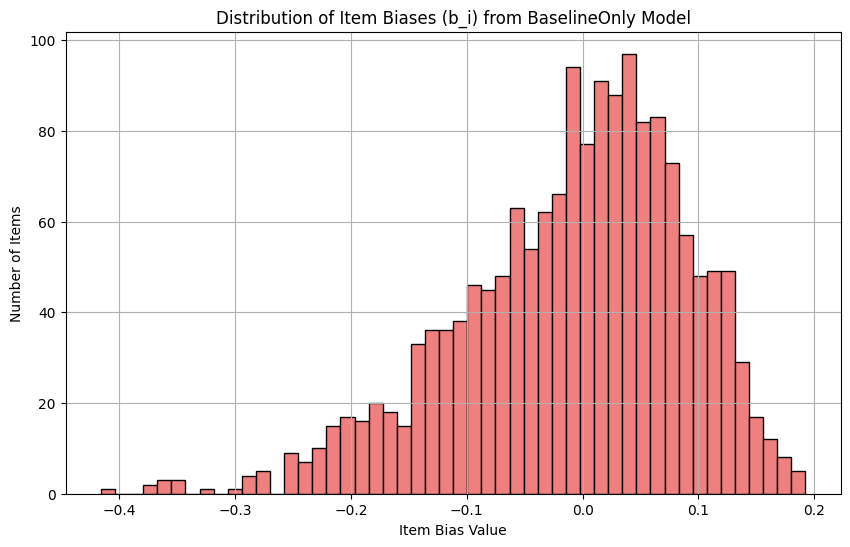

In [96]:
# Fit the model on the full training set
trainset = train_data.build_full_trainset()
baseline_model.fit(trainset)

# Get item biases (indexed by inner IDs)
item_biases = baseline_model.bi  # list of biases for items

# Plot histogram of item biases
plt.figure(figsize=(10, 6))
plt.hist(item_biases, bins=50, color='lightcoral', edgecolor='black')
plt.title("Distribution of Item Biases (b_i) from BaselineOnly Model")
plt.xlabel("Item Bias Value")
plt.ylabel("Number of Items")
plt.grid(True)
plt.show()



**BaselineOnly Model**

“We’ve built a system that predicts how a guest might rate a listing based on patterns in previous reviews. It looks at two main things:

How generous or strict each guest usually is with ratings (some give 5 stars easily, others rarely do), and

How well each listing is typically rated (some places naturally get higher ratings than others).

Using just these two pieces — the guest’s general behavior and the listing’s usual rating — we can make a surprisingly accurate guess of what a guest might think of a place.”

**Analogy for understanding the bias**

“Imagine you have a friend who always gives restaurants a 5-star review, even when the food is just okay. And another friend who’s much more critical and rarely gives more than 3 stars. Our model recognizes this difference and adjusts predictions based on that.

The same goes for listings — some homes consistently get great feedback, while others are more hit-or-miss. We factor that in too.”

**Visuals (Scattered plot)**

“We also looked at how individual listings tend to be rated compared to the average. The chart shows that most listings are close to the average (centered), but some stand out as either really good or not-so-great — those are the dots further away from the center. This helps us understand which properties consistently impress guests, and which might need attention.”


“We used a smart system that looks beyond just the star ratings and tries to understand why guests rate places the way they do. It finds patterns in what guests like and how listings perform. This helps us predict what kinds of listings guests will enjoy — and gives us insights into what makes a listing stand out.”

Most listings cluster around the center, meaning they share common characteristics and rating patterns

Some listings are far from the center, which may indicate unique or polarizing properties — these are worth examining more closely.

This kind of insight can help platform managers or hosts:

Identify standout listings,

Spot anomalies or issues,

Improve recommendation systems.